# An Exploration of Lethal Outcomes in Cases of Myocardial Infarction using Deep Learning

#### <center>Yi-Jin Chen, John Arnn, Luis Alegria</center>

### <center>Introduction</center>

&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Myocardial infarctions (MI), commonly referred to as heart attacks, occur after a blockage in the blood vessels supplying oxygen to heart muscles. This medical condition is considered life-threatening, and individuals not administered medical treatments promptly can have lethal outcomes. Certain risk factors and conditions predispose individuals to suffer heart attacks. These include hypertension, cigarette smoking, type II diabetes, and a sedentary lifestyle (1). In the United States, an estimated 805,000 individuals suffer a heart attack annually, and 1 in 5 may not perceive that they have suffered one (2). Given that heart attacks are prevalent and can lead to loss of life, it is essential to determine factors and medical treatments that can reduce the possibility of a lethal outcome. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; Our group chose to analyze a data set collected by Golovenkin et al. to explore MI using deep learning methods (3). This set contains information for MI patients seen at Krasnoyarsk Interdistrict Clinical Hospital in Russia from 1992-1995. It consists of 111 features, excluding the ID column, and 12 outcomes. Of the 111 features, nine were collected at various time points after hospital admission. For the outcomes, 11 have binary classes while one, lethal outcome,  has eight classes. The main objective of the analysis will be to use the features at the time of admission to classify lethal outcome after transformation into a binary class. Other objectives include: explore the data set with visualizations, drop features with more than 50%, find features that are correlated, train fully-connected and convolutional neural networks and measure their performance, both in unoptimized and optimized states, and analyze the data using an autoencoder. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; A literature review reveals several investigations into the MI topic. Convolutional neural networks have been used to detect MI from electrocardiogram data (4). In another study focused on the same type of data, ensemble neural networks were employed to study the problem (5). Fully-connected architectures have also been used to investigate MI classification (6). 

####  <center> Imports </cemter>

In [1]:
from numpy.random import seed
seed(0)

import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
tf.random.set_seed(1)
from tensorflow import keras
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
import tensorflow.keras.backend as K

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

plt.style.use('seaborn-darkgrid')

from warnings import simplefilter 
simplefilter(action='ignore', category=UserWarning)

In [2]:
tf.__version__

'2.4.1'

### <center> Data Preparation </center>

To prepare the data set for analysis the following are performed:
- drop ID column
- drop features recorded after patient admission to hospital
- drop outcomes not related to mortality
- convert mortality outcome from multi-class to binary class.

In [3]:
# Read CSV file containing the data.
mi = pd.read_csv('./data_csv/Myocardial infarction complications Database.csv')

In [4]:
# In its raw state, the data set contains 1700 instances with 124 columns. 
mi.shape

(1700, 124)

In [5]:
# First few entries of the set# ID, features after admission, 
# and any outcome not lethal outcome needs to be removed

# features after admission : First three are for pain relapse, second three for use
# opioids in the ICU, last three for use of NSAIDs

# Outcomes to be dropped: Atrial fibrillation, Supraventricular tachycardia, 
# Ventricular tachycardia, Ventricular fibrillation, Third-degree AV block,
# Pulmonary edema, Myocardial rupture, Dressler syndrome, Chronic heart failure,
# Relapse of the myocardial infarction, Post-infarction angina

#list of column labels to be dropped
drop_columns = ['ID',
               'R_AB_1_n', 'R_AB_2_n', 'R_AB_3_n', 'NA_R_1_n', 'NA_R_2_n',
               'NA_R_3_n', 'NOT_NA_1_n', 'NOT_NA_2_n', 'NOT_NA_3_n',
               'FIBR_PREDS', 'PREDS_TAH', 'JELUD_TAH', 'FIBR_JELUD', 'A_V_BLOK',
               'OTEK_LANC', 'RAZRIV', 'DRESSLER', 'ZSN', 'REC_IM', 'P_IM_STEN']

mi = mi.drop(columns = drop_columns)

# after the drops, there is 102 features and the outcome
mi.shape

(1700, 103)

In [6]:
# outcome has eight classes
mi['LET_IS'].value_counts()

0    1429
1     110
3      54
7      27
6      27
4      23
2      18
5      12
Name: LET_IS, dtype: int64

In [7]:
mi = mi.replace({'LET_IS': [i for i in range(1, 8)]}, 1)
mi['LET_IS'].value_counts()

0    1429
1     271
Name: LET_IS, dtype: int64

### <center> Descriptive Statistics and Missing Values </center>

In this section the aim is to explore the dataset using descriptive statistics and visualizations as well as investigate missing values in the data set.

In [8]:
# Separate the data into featurea and outcome or target
X = mi.drop(columns = ['LET_IS'])
y = mi['LET_IS']

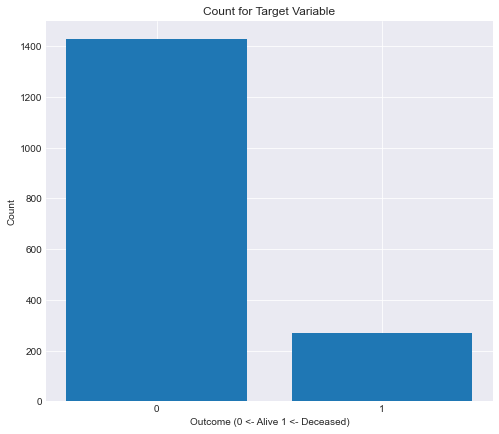

In [9]:
# bar plot to visualize counts of outcome values
# The plot shows that the data is unbalanced
fig, ax = plt.subplots(figsize = (8, 7))
ax.bar(x = [0, 1], height = y.value_counts())
ax.set_xticks([0, 1])
ax.set_xlabel('Outcome (0 <- Alive 1 <- Deceased)')
ax.set_ylabel('Count')
ax.set_title('Count for Target Variable')
plt.show()

In [10]:
# There are many features are not numeric, because they use number to classify. 
# They're actually categorical features.
# Binary data was treated as categorical data; ordinal data was treated as continuous variables (numerical) for simpler interpretation. 
# Reason from: https://www3.nd.edu/~rwilliam/stats3/OrdinalIndependent.pdf

# List to hold integer values of columns with numerical features
features = [0, *range(2,6), 7, 9, 10, *range(33,37), *range(43,47), 82, *range(84,91)]

# List to hold integer values of columns with categorical values
categories = [i for i in range(X.columns.size) if not (i in features)]

# locate all numerical features
numfeatures = X.iloc[:, features]

# locate all categorical features
catfeatures = X.iloc[:, categories]

# Print the total number in each category
print('The total number of numerical features:', len(numfeatures.columns))
print('The total number of categorical features:', len(catfeatures.columns))

The total number of numerical features: 24
The total number of categorical features: 78


In [11]:
# Describe method on the numerical features
numfeatures.describe()

,AGE,INF_ANAM,STENOK_AN,FK_STENOK,IBS_POST,GB,DLIT_AG,ZSN_A,S_AD_KBRIG,D_AD_KBRIG,...,inf_im,post_im,K_BLOOD,NA_BLOOD,ALT_BLOOD,AST_BLOOD,KFK_BLOOD,L_BLOOD,ROE,TIME_B_S
count,1692.000000,1696.000000,1594.000000,1627.000000,1649.000000,1691.000000,1452.000000,1646.000000,624.000000,624.000000,...,1620.000000,1628.000000,1329.000000,1325.000000,1416.000000,1415.000000,4.000000,1575.000000,1497.000000,1574.000000
mean,61.856974,0.554835,2.316186,1.205286,1.160703,1.393258,3.340220,0.194411,136.907051,81.394231,...,1.014815,0.259214,4.191422,136.550943,0.481455,0.263717,2.000000,8.782914,13.444890,4.684244
std,11.259936,0.836801,2.440586,1.040814,0.801400,1.088803,3.098646,0.658722,34.997835,19.745045,...,1.404934,0.698850,0.754076,6.512120,0.387261,0.201802,1.095445,3.400557,11.296316,2.871044
min,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,2.300000,117.000000,0.030000,0.040000,1.200000,2.000000,1.000000,1.000000
25%,54.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,120.000000,70.000000,...,0.000000,0.000000,3.700000,133.000000,0.230000,0.150000,1.350000,6.400000,5.000000,2.000000
50%,63.000000,0.000000,1.000000,2.000000,1.000000,2.000000,3.000000,0.000000,140.000000,80.000000,...,0.000000,0.000000,4.100000,136.000000,0.380000,0.220000,1.600000,8.000000,10.000000,4.000000
75%,70.000000,1.000000,5.000000,2.000000,2.000000,2.000000,7.000000,0.000000,160.000000,90.000000,...,2.000000,0.000000,4.600000,140.000000,0.610000,0.330000,2.250000,10.450000,18.000000,7.000000
max,92.000000,3.000000,6.000000,4.000000,2.000000,3.000000,7.000000,4.000000,260.000000,190.000000,...,4.000000,4.000000,8.200000,169.000000,3.000000,2.150000,3.600000,27.900000,140.000000,9.000000


From the describe method, we see that for this data set the average age for the individuals is 61.9. This means that myocardial infarctions typically occur in older individuals.  

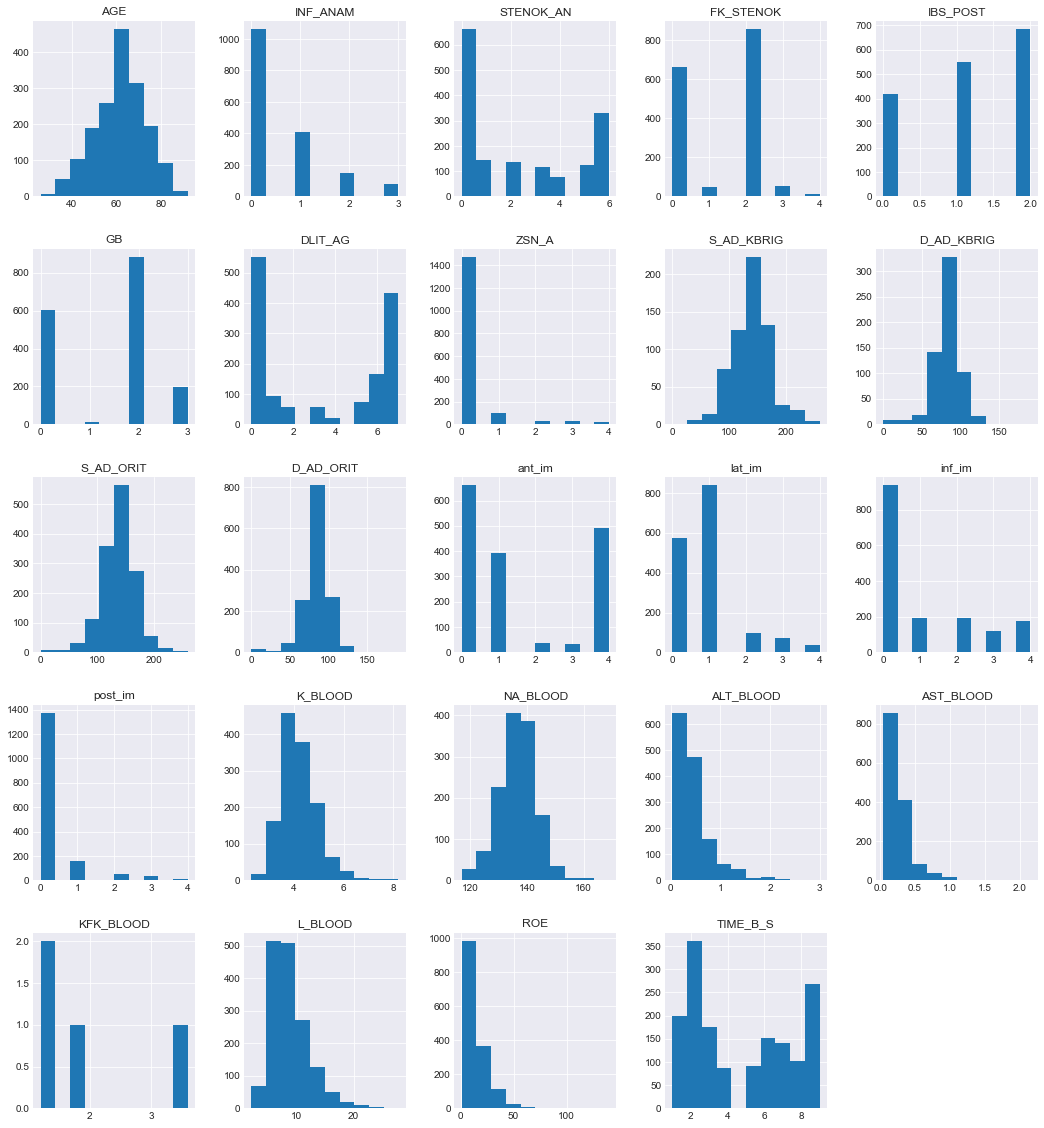

In [12]:
# Histogram for numerical features
X[numfeatures.columns].hist(figsize=(18,20))
plt.show()

*Discussion of Histograms of Numerical Features:* Some of the numerical features follow a normal distribution. These features are: age, lat_im, inf_im, post_im, K_Blood, L_Blood, ROE. Some are right-skewed. These include: Alt_blood, AST_blood. One appear to be bi-modal (TIME_B_S). 

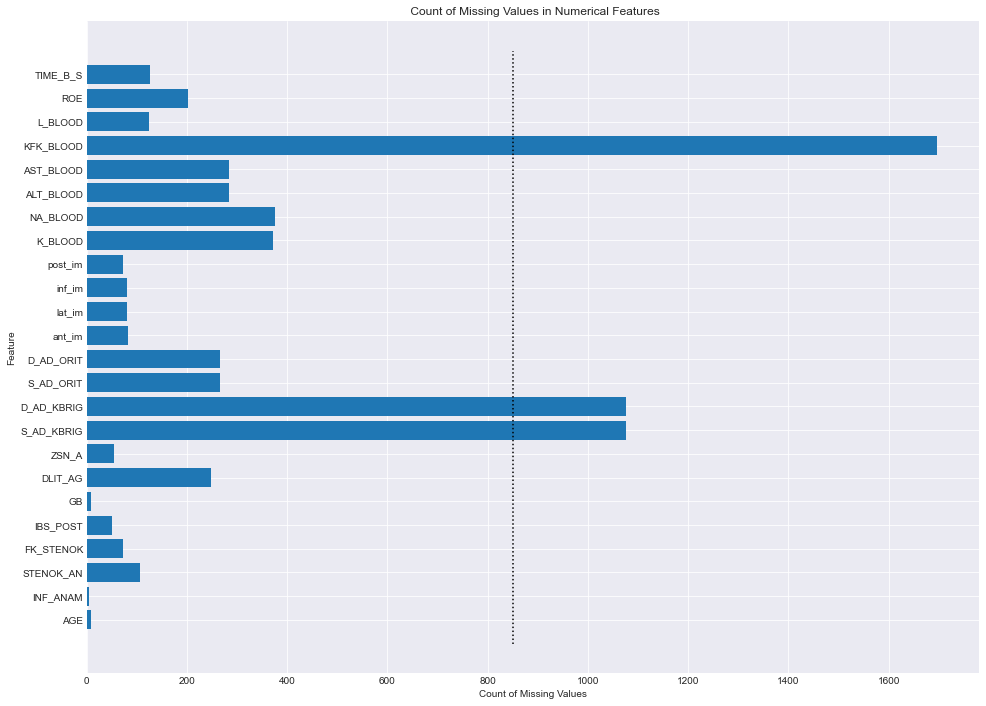

In [13]:
# Visualization of missing values in the dats set with a horizontal bar plot
# Any feature with > 50% missing values will be dropped. 

# Count of missing values.
na_count = X[numfeatures.columns].isnull().sum()
# list to hold values 0-23
marks = [i for i in range(0, len(na_count))]

fig, ax = plt.subplots(figsize = (16, 12))
ax.barh(y = marks, width = na_count.values)
ax.set_yticks(marks)
ax.set_yticklabels(na_count.index)
ax.set_xlabel('Count of Missing Values')
ax.set_ylabel('Feature')
ax.set_title(' Count of Missing Values in Numerical Features')
plt.vlines(x = 1700 / 2, ymin = -1 , ymax = 24, color = 'black',
          linestyles = 'dotted')
plt.show()

The features S_AD_KBRIG, D_AD_KBRIG, and KFK_BLOOD will be dropped since they have greater than 50% missing values.

In [14]:
newnumfeatures = numfeatures.loc[:, (numfeatures.isnull().sum(axis=0) < 1700/2)]

To explore if any of the numerical features are correlated a heat map is used. 

In [15]:
#Correlation for numerical features
cors = X[newnumfeatures.columns].corr()
# Mask with shape equivalent to numerical features
mask = np.zeros_like(cors)
#Perform mask
mask[np.triu_indices_from(mask, k=1)] = True

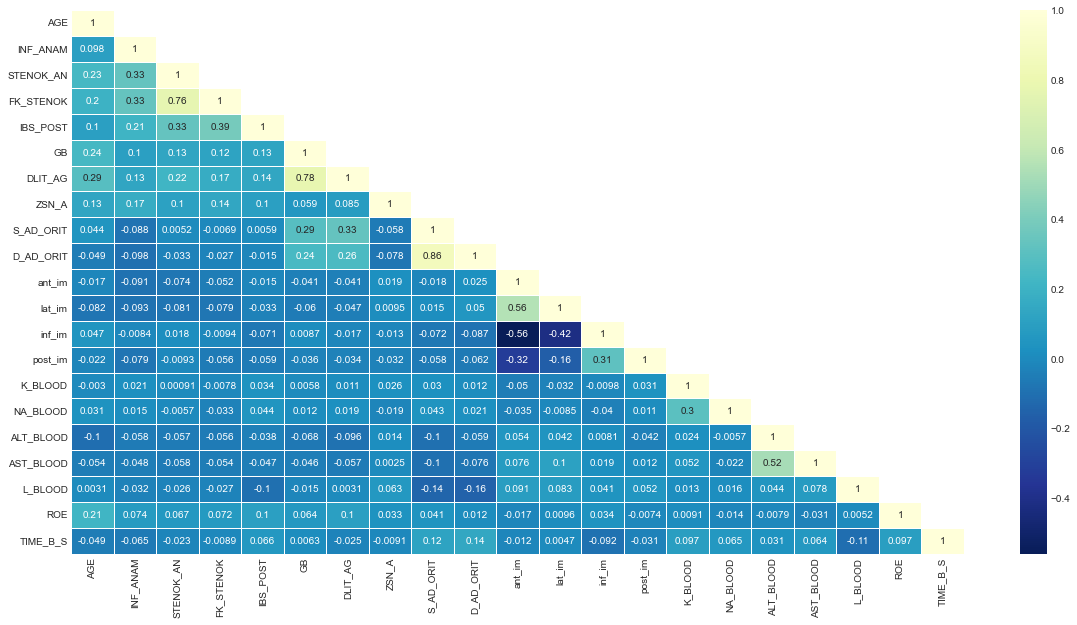

In [16]:
# Generate heatmap
with sns.axes_style('white'):
    f, ax = plt.subplots(figsize=(20, 10))
    ax = sns.heatmap(cors, mask=mask, annot=True, linewidths=.5, cmap="YlGnBu_r")

Analysis of Heatmap: The most positively correlated features are D_AD_ORIT and S_AD_ORIT. The most negatively correlated are inf_im and ant_im.

To look at missing values for categorical features a horizontal bar plot will also be used. 

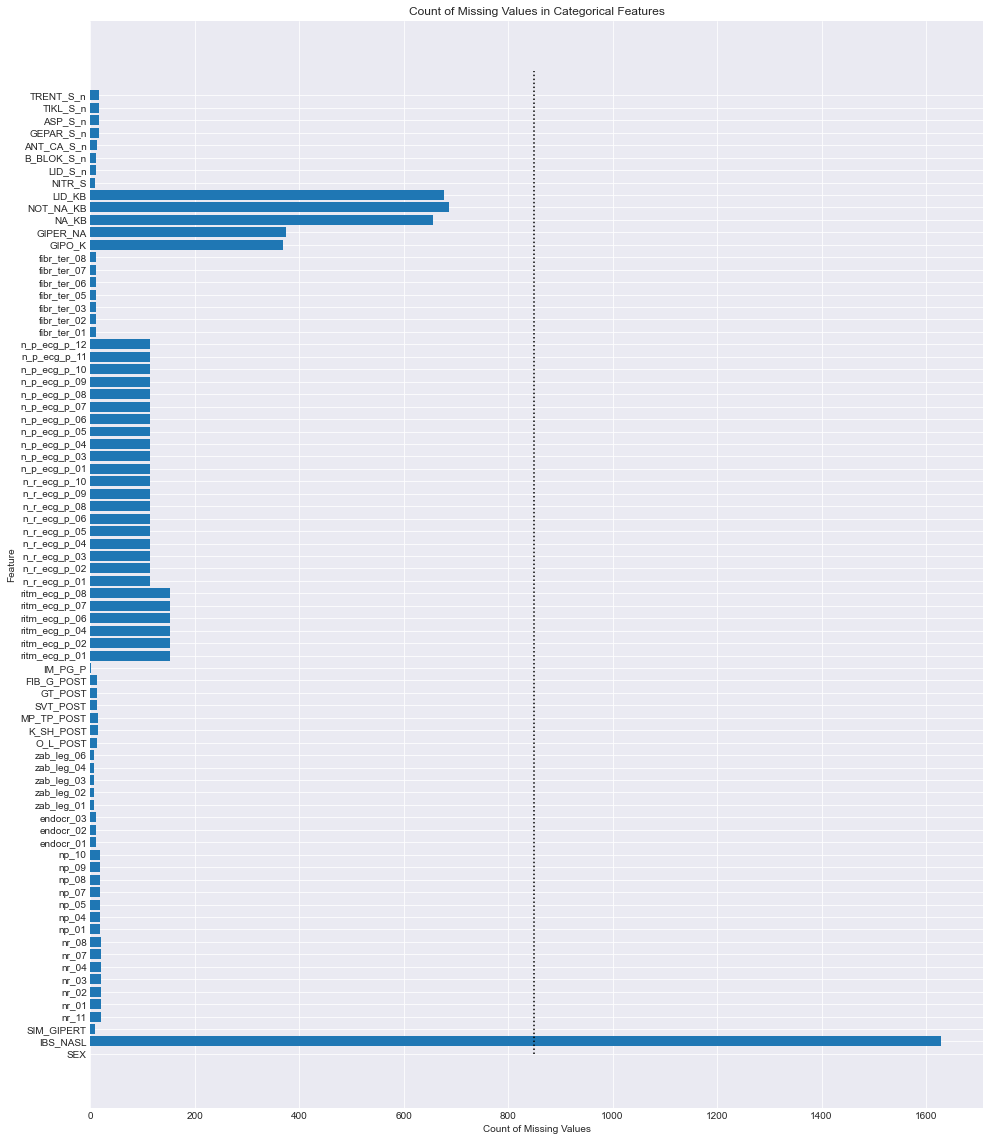

In [17]:
# Visualization of missing values in the dats set with a horizontal bar plot
# Any feature with > 50% missing values will be dropped. 

# Count of missing values.
na_count_cat = X[catfeatures.columns].isnull().sum()
# list to hold values 0-23
marks_cat = [i for i in range(0, len(na_count_cat))]

fig, ax = plt.subplots(figsize = (16, 20))
ax.barh(y = marks_cat, width = na_count_cat.values)
ax.set_yticks(marks_cat)
ax.set_yticklabels(na_count_cat.index)
ax.set_xlabel('Count of Missing Values')
ax.set_ylabel('Feature')
ax.set_title('Count of Missing Values in Categorical Features')
plt.vlines(x = 1700 / 2, ymin = 0 , ymax = 79, color = 'black',
          linestyles = 'dotted')
plt.show()

Since the feature IBS_NASL has >50% missing values, it will be dropped. 

In [18]:
newcatfeatures = catfeatures.loc[:, (catfeatures.isnull().sum(axis=0) < 1700/2)]

In [19]:
# Dropped the features from the analysis above
X = X.drop(columns = ['S_AD_KBRIG', 'D_AD_KBRIG', 'KFK_BLOOD','IBS_NASL'])
# Display shape before test-train split
X.shape

(1700, 98)

### <center> Test-Train Split </center>

The test train split will be stratified due to the imbalance of the outcome variable. In the following cell, the parameter stratify = y ensures that the same proportions of outcome variable is maintained in the splits. To ensure that we are all working with the same data, the splits will be converted to a pandas dataframe, exported to a csv file and place in out git repository. 

In [20]:
# From data exploration we found that the target varible is unbalanced so
# the data will be split in a stratified manner. 

# X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, test_size = 0.2,
#                                                    random_state = 42, stratify = y)

In [21]:
# concatanate training set
# df_train = pd.concat([X_train, y_train], axis = 1)

# concanate test set
# df_test = pd.concat([X_test, y_test], axis = 1)

In [22]:
# write data to csv
# df_train.to_csv('train')

# write data to csv
# df_test.to_csv('test')

### <center> Preparing Test-Train Split </center>

In [23]:
# Creation of imputer instances for categorical, numerical features, and MinMaxScaler
impute_num = SimpleImputer(missing_values = np.nan, strategy = 'median')
impute_cat = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
min_max_scaler = MinMaxScaler()

In [24]:
# In this cell we create two lists containing the name of numerical and categorical 
# features. Also dictionaries for later type casting are created. 

num = ['AGE', 'INF_ANAM', 'STENOK_AN', 'FK_STENOK', 'IBS_POST', 'GB',
       'DLIT_AG', 'ZSN_A', 'S_AD_ORIT', 'D_AD_ORIT', 'ant_im', 'lat_im',
       'inf_im', 'post_im', 'K_BLOOD', 'NA_BLOOD', 'ALT_BLOOD', 'AST_BLOOD',
       'L_BLOOD', 'ROE', 'TIME_B_S']

num_type = ['float']

cat = ['SEX', 'SIM_GIPERT', 'nr_11', 'nr_01', 'nr_02', 'nr_03', 'nr_04',
       'nr_07', 'nr_08', 'np_01', 'np_04', 'np_05', 'np_07', 'np_08', 'np_09',
       'np_10', 'endocr_01', 'endocr_02', 'endocr_03', 'zab_leg_01',
       'zab_leg_02', 'zab_leg_03', 'zab_leg_04', 'zab_leg_06', 'O_L_POST',
       'K_SH_POST', 'MP_TP_POST', 'SVT_POST', 'GT_POST', 'FIB_G_POST',
       'IM_PG_P', 'ritm_ecg_p_01', 'ritm_ecg_p_02', 'ritm_ecg_p_04',
       'ritm_ecg_p_06', 'ritm_ecg_p_07', 'ritm_ecg_p_08', 'n_r_ecg_p_01',
       'n_r_ecg_p_02', 'n_r_ecg_p_03', 'n_r_ecg_p_04', 'n_r_ecg_p_05',
       'n_r_ecg_p_06', 'n_r_ecg_p_08', 'n_r_ecg_p_09', 'n_r_ecg_p_10',
       'n_p_ecg_p_01', 'n_p_ecg_p_03', 'n_p_ecg_p_04', 'n_p_ecg_p_05',
       'n_p_ecg_p_06', 'n_p_ecg_p_07', 'n_p_ecg_p_08', 'n_p_ecg_p_09',
       'n_p_ecg_p_10', 'n_p_ecg_p_11', 'n_p_ecg_p_12', 'fibr_ter_01',
       'fibr_ter_02', 'fibr_ter_03', 'fibr_ter_05', 'fibr_ter_06',
       'fibr_ter_07', 'fibr_ter_08', 'GIPO_K', 'GIPER_NA', 'NA_KB',
       'NOT_NA_KB', 'LID_KB', 'NITR_S', 'LID_S_n', 'B_BLOK_S_n', 'ANT_CA_S_n',
       'GEPAR_S_n', 'ASP_S_n', 'TIKL_S_n', 'TRENT_S_n']

cat_type = ['Int64']
cat_type2 = ['int']

# dictionaries for type casting

num_dict = dict()
cat_dict = dict()
cat2_dict = dict()

for typ_n in num_type:
    for column in num:
        num_dict[column] = typ_n
        
for typ_c in cat_type:
    for column in cat:
        cat_dict[column] = typ_c
        
for typ_2c in cat_type2:
    for column in cat:
        cat2_dict[column] = typ_2c

# works for Python 3.9.0 or greater, merge two dictionaries
types = num_dict | cat_dict
types2 = num_dict | cat2_dict

# In Python 3.5 or greater
# types = {**num_dict, **cat_dict}

In [25]:
# read files with data already split into training and testing sets
train = pd.read_csv('./jly-dl-project/train', dtype=types, index_col=0)

test = pd.read_csv('./jly-dl-project/test', dtype=types, index_col=0)

In [26]:
# impute missing values on training
train[num] = impute_num.fit_transform(train[num])
train[cat] = impute_cat.fit_transform(train[cat])

# impute missing vaues on training
test[num] = impute_num.fit_transform(test[num])
test[cat] = impute_cat.fit_transform(test[cat])

In [27]:
# cast features to types
train = train.astype(dtype=types2)
train['AGE'] = train['AGE'].astype('int')

test = test.astype(dtype=types2)
test['AGE'] = test['AGE'].astype('int')

In [28]:
# perform min_max scaling on numerical features
train[num] = min_max_scaler.fit_transform(train[num])

test[num] = min_max_scaler.fit_transform(test[num])

In [29]:
# Split data into X and y vectors
X_train = train.drop(columns=['LET_IS'])
y_train = train['LET_IS']

X_test = test.drop(columns=['LET_IS'])
y_test = test['LET_IS']

### <center> Data Reshaping and Validation Set </center>

Currently, the data has a two-dimensional shape. The tf.keras.layers.Conv1D layer requires a three-dimensional shape. According to the Tensorflow, `3+D tensor with shape: batch_shape + (steps, input_dim)` In addition, the training set will be undergo a further stratified split to create a validation set. 

In [30]:
# shape of training data
X_train.shape

(1360, 98)

In [31]:
#Reshape data so it's compatible with Conv1D layer
X_train_reshaped = np.reshape(np.array(X_train), (X_train.shape[0], X_train.shape[1], 1))
X_test_reshaped = np.reshape(np.array(X_test), (X_test.shape[0], X_test.shape[1], 1))


# convert target variables
y_train_cnn = np.array(y_train)
y_test_cnn = np.array(y_test)

print(f'X_train_reshaped shape: {X_train_reshaped.shape}')
print(f'X_test_reshaped shape: {X_test_reshaped.shape}')

X_train_reshaped shape: (1360, 98, 1)
X_test_reshaped shape: (340, 98, 1)


### <center> CNN Model without Optimization </center>

Here a CNN model is built without optimization. A function is defined to compute f1 score.

#taken from old keras source code<br>
source:<br>
[f1 function link](https://aakashgoel12.medium.com/how-to-add-user-defined-function-get-f1-score-in-keras-metrics-3013f979ce0d)

In [32]:
# function to compute f1 score in models
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [33]:
#function to built the model
def build_conv1D_model():
    # Shape of inputs
  n_timesteps, n_features = X_train_reshaped.shape[1], X_train_reshaped.shape[2] #98,1
    # Sequential class
  model = keras.Sequential(name="conv1D_not_optimized")
    # Add input layer
  model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
    # Conv1D layer
  model.add(keras.layers.Conv1D(filters=14, kernel_size=7, activation='relu'))
    # Dropout layer
  model.add(keras.layers.Dropout(0.2))
    # Second Conv1D layer
  model.add(keras.layers.Conv1D(filters=7, kernel_size=5, activation='relu'))
    #batch normalization layer
#   model.add(keras.layers.BatchNormalization())
    # Third Conv1D layer
  model.add(keras.layers.Conv1D(filters=3, kernel_size=3, activation='relu'))
    # Pooling layer
  model.add(keras.layers.MaxPooling1D(pool_size=3))
    # Flatten Tensor 
  model.add(keras.layers.Flatten())
    # Dense layer with 32 units
  model.add(keras.layers.Dense(6, activation='relu'))
    # Output layer with 1 unit and sigmoid activation function for prediction
  model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Model compile with loss, optimizer, and metric
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[get_f1])
    #return model
  return model

# call function to build model
model_conv1D = build_conv1D_model()
# display summary
model_conv1D.summary()

Model: "conv1D_not_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 92, 14)            112       
_________________________________________________________________
dropout (Dropout)            (None, 92, 14)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 88, 7)             497       
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 86, 3)             66        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 28, 3)             0         
_________________________________________________________________
flatten (Flatten)            (None, 84)                0         
_________________________________________________________________
dense (Dense)                (None, 6)        

In [34]:
#callbacks
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=1)
logger = keras.callbacks.CSVLogger('cnn_not_opt', separator=',', append=True)

In [35]:
#train the model
history_not_opt = model_conv1D.fit(X_train_reshaped, y_train_cnn, batch_size=64,
                                   validation_data=(X_test_reshaped, y_test_cnn), verbose=1,
                                  epochs=200, callbacks=[early_stop])

Epoch 1/200
22/22 [==============================] - 2s 46ms/step - loss: 0.6209 - get_f1: 0.0000e+00 - val_loss: 0.4739 - val_get_f1: 0.0000e+00
Epoch 2/200
22/22 [==============================] - 0s 11ms/step - loss: 0.4509 - get_f1: 0.0000e+00 - val_loss: 0.4409 - val_get_f1: 0.0000e+00
Epoch 3/200
22/22 [==============================] - 0s 11ms/step - loss: 0.4430 - get_f1: 0.0000e+00 - val_loss: 0.4333 - val_get_f1: 0.0000e+00
Epoch 4/200
22/22 [==============================] - 0s 11ms/step - loss: 0.4306 - get_f1: 0.0000e+00 - val_loss: 0.4260 - val_get_f1: 0.0000e+00
Epoch 5/200
22/22 [==============================] - 0s 12ms/step - loss: 0.4274 - get_f1: 0.0000e+00 - val_loss: 0.4170 - val_get_f1: 0.0000e+00
Epoch 6/200
22/22 [==============================] - 0s 11ms/step - loss: 0.4165 - get_f1: 0.0000e+00 - val_loss: 0.4095 - val_get_f1: 0.0000e+00
Epoch 7/200
22/22 [==============================] - 0s 15ms/step - loss: 0.4103 - get_f1: 0.0000e+00 - val_loss: 0.3995 - v

In [35]:
# Save Model
# model_conv1D.save('cnn_1_not_opt')

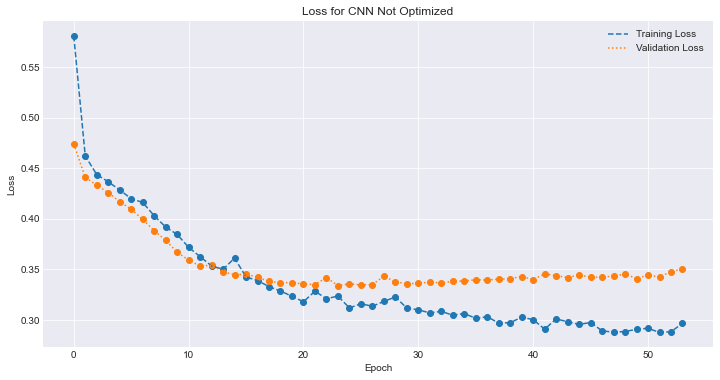

In [68]:
# Generate Visualization for Training and Validation Loss
x_vals = [*range(len(history_not_opt.history['loss']))]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(x_vals, history_not_opt.history['loss'], '--', label='Training Loss')
ax.scatter(x_vals, history_not_opt.history['loss'])
ax.plot(x_vals, history_not_opt.history['val_loss'], ':', label='Validation Loss')
ax.scatter(x_vals, history_not_opt.history['val_loss'])

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

plt.title('Loss for CNN Not Optimized')
plt.show()

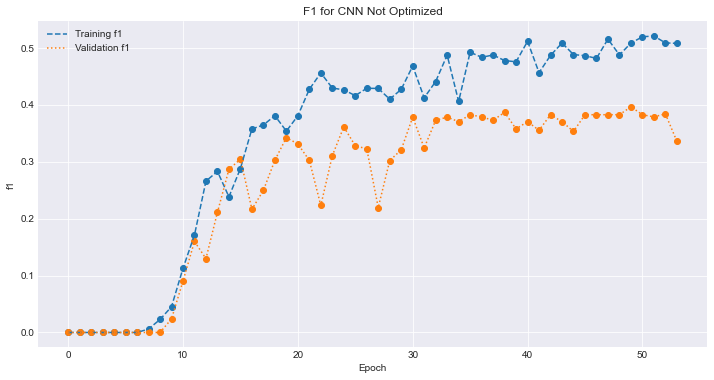

In [70]:
# generate f1 visualization
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(x_vals, history_not_opt.history['get_f1'], '--', label='Training f1')
ax.scatter(x_vals, history_not_opt.history['get_f1'])
ax.plot(x_vals, history_not_opt.history['val_get_f1'], ':', label='Validation f1')
ax.scatter(x_vals, history_not_opt.history['val_get_f1'])

ax.set_xlabel('Epoch')
ax.set_ylabel('f1')
ax.legend()

plt.title('F1 for CNN Not Optimized')
plt.show()

In [40]:
print(f'mean f1 on training set: {np.mean(history_not_opt.history["get_f1"])}')

mean f1 on training set: 0.3471290132513753


In [41]:
print (f'mean f1 on validation set: {np.mean(history_not_opt.history["val_get_f1"])}')

mean f1 on validation set: 0.2645321649809678


*Summary of First CNN Model Training:* This model appears to have overfit the training data as is observed for both the loss and f1 plots.

#### <center> CNN Model Not Optimized Performance on Test Data </center>

In [42]:
# Model predictions on test data
pred_1 = model_conv1D.predict(X_test_reshaped)

In [43]:
# convert probabilities with 0.5 threshold
pred_1 = np.where(pred_1 > 0.5, 1, 0)

In [44]:
# classification report
print(classification_report(y_test_cnn, pred_1))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92       286
           1       0.65      0.28      0.39        54

    accuracy                           0.86       340
   macro avg       0.76      0.62      0.66       340
weighted avg       0.84      0.86      0.84       340



In [46]:
# f1 score 
print(f'f1-score for unoptimized model test data: {f1_score(y_test_cnn, pred_1)}')

f1-score for unoptimized model test data: 0.3896103896103896


*Summary of Unoptimized model performance on Test set: * The model had a higher f1 score than the average on the training set. Training-f1: 0.35 Testing-f1: 0.39

#### <center> CNN Model Optimization </center>

The CNN model from the previous section is optimized. Here the parameters investigated are: activation functions, kernel initializers for weights, optimizers, batch size, and epochs. 

In [40]:
def build_conv1D_model_opt(activation='relu', initializer='glorot_uniform',
                          optimizer='adam'):
    # Shape of inputs
  n_timesteps, n_features = X_train_reshaped.shape[1], X_train_reshaped.shape[2] #98,1
    # Sequential class
  model = keras.Sequential()
    # if block to assign activation function and kernel_initializer
  if activation:
        # Add input layer
      model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
        # Conv1D layer
      model.add(keras.layers.Conv1D(filters=14, kernel_size=7, activation=activation,
                                   kernel_initializer=initializer))
        # Dropout layer
      model.add(keras.layers.Dropout(0.2))
        # Second Conv1D layer
      model.add(keras.layers.Conv1D(filters=7, kernel_size=5, activation=activation,
                                   kernel_initializer=initializer))
        # Third Conv1D layer
      model.add(keras.layers.Conv1D(filters=3, kernel_size=3, activation=activation,
                                   kernel_initializer=initializer))
        # Pooling layer
      model.add(keras.layers.MaxPooling1D(pool_size=3))
        # Flatten Tensor 
      model.add(keras.layers.Flatten())
        # Dense layer with 32 units
      model.add(keras.layers.Dense(6, activation=activation,
                                   kernel_initializer=initializer))
    # Output layer with 1 unit and sigmoid activation function for prediction
  model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Model compile with loss, optimizer, and metric
    # Accuracy metric specified to avoid errors RandomizedSearch CV returned f1
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    #return model
  return model


In [41]:
#use wrapper for CNN build model function
model_for_rand_search = KerasClassifier(build_fn=build_conv1D_model_opt,
                                       verbose=0)
# cv method will need to be stratified
cv_strat= StratifiedKFold(n_splits=5, shuffle= True, random_state=5)

In [42]:
# define the search space
params = {
    'activation': ['relu', 'tanh', 'sigmoid'],
    'optimizer': ['sgd', 'adam', 'adadelta', 'nadam'],
    'initializer':['glorot_uniform', 'glorot_normal', 'random_normal', 'random_uniform',
              'he_normal', 'he_uniform'],
    'batch_size': [1, 4, 8, 16, 32, 64],
    'epochs': [10, 20, 25, 30, 35, 40, 45, 50, 60, 80, 100]
}

In [43]:
# Specify the parameters that will be passed to RandomizedSearchCV
                                    #CNN model
rand_search = RandomizedSearchCV(estimator=model_for_rand_search,
                                 #Parameter space
                                param_distributions=params,
                                 #scoring
                                scoring = 'f1',
                                 # number of iterations
                                n_iter=30,
                                n_jobs=1,
                                 #Stratified k-fold with k=5
                                cv=cv_strat,
                                 #display info
                                verbose=10,
                                 #set random state
                                random_state=3)

In [44]:
# Perform the search ... takes a while ... 
rand_search.fit(X_train_reshaped, y_train_cnn)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV 1/5; 1/30] START activation=tanh, batch_size=1, epochs=35, initializer=random_normal, optimizer=sgd
[CV 1/5; 1/30] END activation=tanh, batch_size=1, epochs=35, initializer=random_normal, optimizer=sgd;, score=0.433 total time=  51.0s
[CV 2/5; 1/30] START activation=tanh, batch_size=1, epochs=35, initializer=random_normal, optimizer=sgd
[CV 2/5; 1/30] END activation=tanh, batch_size=1, epochs=35, initializer=random_normal, optimizer=sgd;, score=0.406 total time=  57.8s
[CV 3/5; 1/30] START activation=tanh, batch_size=1, epochs=35, initializer=random_normal, optimizer=sgd
[CV 3/5; 1/30] END activation=tanh, batch_size=1, epochs=35, initializer=random_normal, optimizer=sgd;, score=0.590 total time= 1.2min
[CV 4/5; 1/30] START activation=tanh, batch_size=1, epochs=35, initializer=random_normal, optimizer=sgd
[CV 4/5; 1/30] END activation=tanh, batch_size=1, epochs=35, initializer=random_normal, optimizer=sgd;, score=0.525 t

[CV 5/5; 7/30] END activation=tanh, batch_size=32, epochs=25, initializer=he_normal, optimizer=nadam;, score=0.312 total time=   5.8s
[CV 1/5; 8/30] START activation=tanh, batch_size=64, epochs=10, initializer=he_normal, optimizer=nadam
[CV 1/5; 8/30] END activation=tanh, batch_size=64, epochs=10, initializer=he_normal, optimizer=nadam;, score=0.089 total time=   3.8s
[CV 2/5; 8/30] START activation=tanh, batch_size=64, epochs=10, initializer=he_normal, optimizer=nadam
[CV 2/5; 8/30] END activation=tanh, batch_size=64, epochs=10, initializer=he_normal, optimizer=nadam;, score=0.000 total time=   2.4s
[CV 3/5; 8/30] START activation=tanh, batch_size=64, epochs=10, initializer=he_normal, optimizer=nadam
[CV 3/5; 8/30] END activation=tanh, batch_size=64, epochs=10, initializer=he_normal, optimizer=nadam;, score=0.130 total time=   2.4s
[CV 4/5; 8/30] START activation=tanh, batch_size=64, epochs=10, initializer=he_normal, optimizer=nadam
[CV 4/5; 8/30] END activation=tanh, batch_size=64, e

[CV 4/5; 14/30] END activation=sigmoid, batch_size=32, epochs=60, initializer=he_normal, optimizer=adam;, score=0.000 total time=  12.5s
[CV 5/5; 14/30] START activation=sigmoid, batch_size=32, epochs=60, initializer=he_normal, optimizer=adam
[CV 5/5; 14/30] END activation=sigmoid, batch_size=32, epochs=60, initializer=he_normal, optimizer=adam;, score=0.000 total time=  12.9s
[CV 1/5; 15/30] START activation=relu, batch_size=64, epochs=50, initializer=random_normal, optimizer=adadelta
[CV 1/5; 15/30] END activation=relu, batch_size=64, epochs=50, initializer=random_normal, optimizer=adadelta;, score=0.000 total time=   7.0s
[CV 2/5; 15/30] START activation=relu, batch_size=64, epochs=50, initializer=random_normal, optimizer=adadelta
[CV 2/5; 15/30] END activation=relu, batch_size=64, epochs=50, initializer=random_normal, optimizer=adadelta;, score=0.000 total time=   8.8s
[CV 3/5; 15/30] START activation=relu, batch_size=64, epochs=50, initializer=random_normal, optimizer=adadelta
[CV

[CV 2/5; 21/30] END activation=sigmoid, batch_size=16, epochs=25, initializer=random_normal, optimizer=nadam;, score=0.000 total time=   8.3s
[CV 3/5; 21/30] START activation=sigmoid, batch_size=16, epochs=25, initializer=random_normal, optimizer=nadam
[CV 3/5; 21/30] END activation=sigmoid, batch_size=16, epochs=25, initializer=random_normal, optimizer=nadam;, score=0.000 total time=   8.9s
[CV 4/5; 21/30] START activation=sigmoid, batch_size=16, epochs=25, initializer=random_normal, optimizer=nadam
[CV 4/5; 21/30] END activation=sigmoid, batch_size=16, epochs=25, initializer=random_normal, optimizer=nadam;, score=0.000 total time=   8.9s
[CV 5/5; 21/30] START activation=sigmoid, batch_size=16, epochs=25, initializer=random_normal, optimizer=nadam
[CV 5/5; 21/30] END activation=sigmoid, batch_size=16, epochs=25, initializer=random_normal, optimizer=nadam;, score=0.000 total time=   8.3s
[CV 1/5; 22/30] START activation=relu, batch_size=16, epochs=25, initializer=he_normal, optimizer=a

[CV 5/5; 27/30] END activation=sigmoid, batch_size=32, epochs=25, initializer=glorot_uniform, optimizer=sgd;, score=0.000 total time=   5.6s
[CV 1/5; 28/30] START activation=tanh, batch_size=16, epochs=80, initializer=he_normal, optimizer=adam
[CV 1/5; 28/30] END activation=tanh, batch_size=16, epochs=80, initializer=he_normal, optimizer=adam;, score=0.583 total time=  25.9s
[CV 2/5; 28/30] START activation=tanh, batch_size=16, epochs=80, initializer=he_normal, optimizer=adam
[CV 2/5; 28/30] END activation=tanh, batch_size=16, epochs=80, initializer=he_normal, optimizer=adam;, score=0.486 total time=  24.0s
[CV 3/5; 28/30] START activation=tanh, batch_size=16, epochs=80, initializer=he_normal, optimizer=adam
[CV 3/5; 28/30] END activation=tanh, batch_size=16, epochs=80, initializer=he_normal, optimizer=adam;, score=0.400 total time=  27.0s
[CV 4/5; 28/30] START activation=tanh, batch_size=16, epochs=80, initializer=he_normal, optimizer=adam
[CV 4/5; 28/30] END activation=tanh, batch_si

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=5, shuffle=True),
                   estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fb737eb9bb0>,
                   n_iter=30, n_jobs=1,
                   param_distributions={'activation': ['relu', 'tanh',
                                                       'sigmoid'],
                                        'batch_size': [1, 4, 8, 16, 32, 64],
                                        'epochs': [10, 20, 25, 30, 35, 40, 45,
                                                   50, 60, 80, 100],
                                        'initializer': ['glorot_uniform',
                                                        'glorot_normal',
                                                        'random_normal',
                                                        'random_uniform',
                                                        'he_normal',
                                  

In [47]:
print(f'Mean cross-validated score of the best_estimator: {rand_search.best_score_}')

Mean cross-validated score of the best_estimator: 0.5437815220459602


print(f'Parameters for best mean score:{rand_search.best_params_}')

Parameters for best mean score:{'optimizer': 'adam', 'initializer': 'he_uniform', 'epochs': 100, 'batch_size': 8, 'activation': 'relu'}

#####  <center> Visualize Performance of Parameters </center>

The following visualizations show the performance of the various parameters. They are represented as violin plots with the actual data points overlayed. 

In [50]:
#store results in a dataframe
df_result = pd.DataFrame(rand_search.cv_results_)

In [56]:
df_result.columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_optimizer', 'param_initializer', 'param_epochs',
       'param_batch_size', 'param_activation', 'params', 'split0_test_score',
       'split1_test_score', 'split2_test_score', 'split3_test_score',
       'split4_test_score', 'mean_test_score', 'std_test_score',
       'rank_test_score'],
      dtype='object')

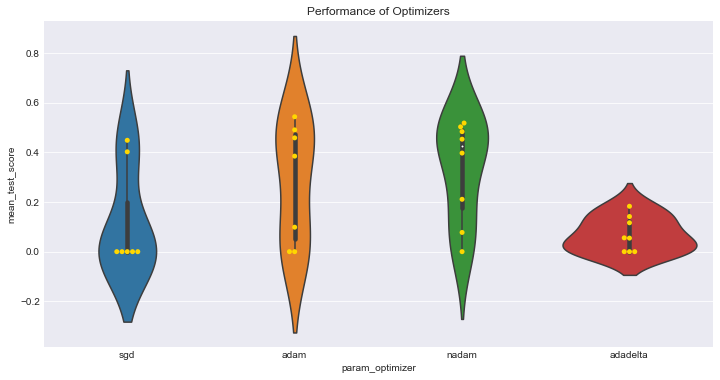

In [93]:
#Optimizers
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.violinplot(data=df_result, x='param_optimizer', y='mean_test_score')
ax = sns.swarmplot(data=df_result, x='param_optimizer', y='mean_test_score', color='gold')
plt.title('Performance of Optimizers')
plt.show()

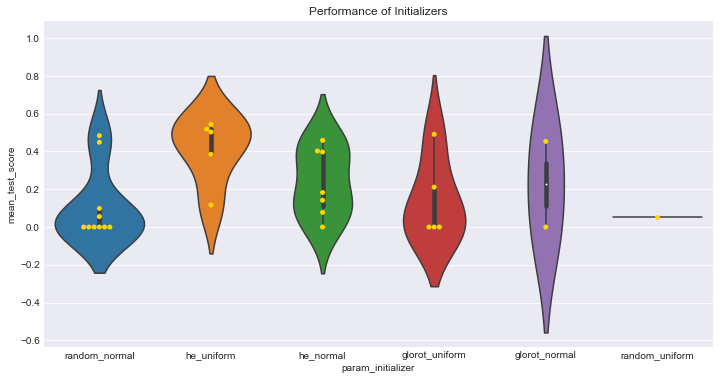

In [95]:
#initializer
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.violinplot(data=df_result, x='param_initializer', y='mean_test_score')
ax = sns.swarmplot(data=df_result, x='param_initializer', y='mean_test_score', color='gold')
plt.title('Performance of Initializers')
plt.show()

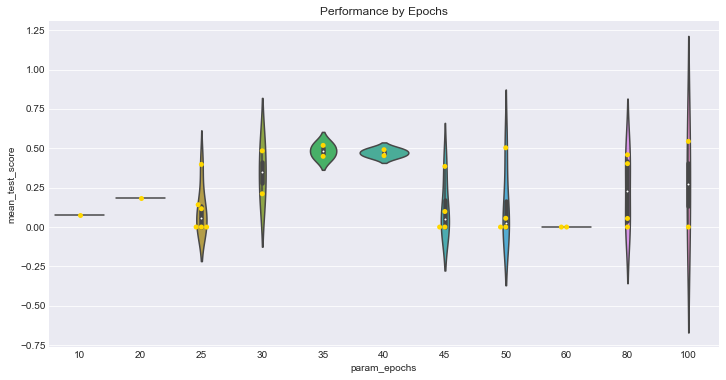

In [96]:
#epochs
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.violinplot(data=df_result, x='param_epochs', y='mean_test_score')
ax = sns.swarmplot(data=df_result, x='param_epochs', y='mean_test_score', color='gold')
plt.title('Performance by Epochs')
plt.show()

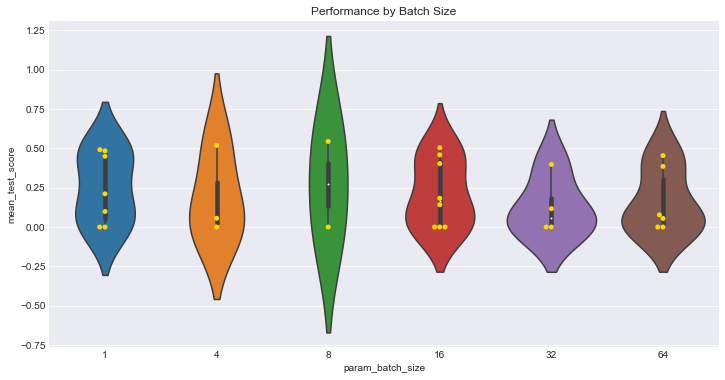

In [99]:
#batch size
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.violinplot(data=df_result, x='param_batch_size', y='mean_test_score')
ax = sns.swarmplot(data=df_result, x='param_batch_size', y='mean_test_score', color='gold')
plt.title('Performance by Batch Size')
plt.show()

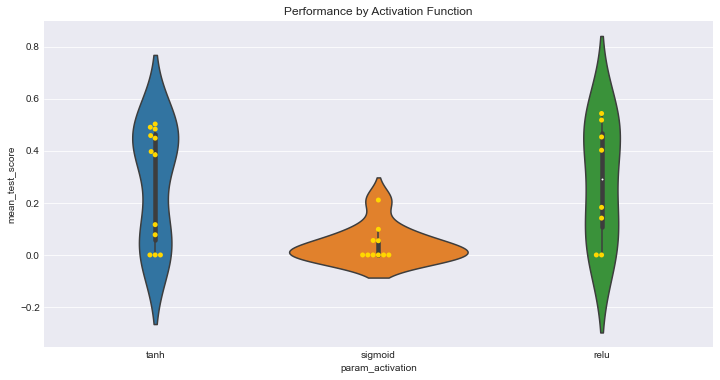

In [98]:
#activation functions
fig, ax = plt.subplots(figsize=(12, 6))
ax = sns.violinplot(data=df_result, x='param_activation', y='mean_test_score')
ax = sns.swarmplot(data=df_result, x='param_activation', y='mean_test_score', color='gold')
plt.title('Performance by Activation Function')
plt.show()

#### <center> Optimized CNN model Performace on Test Data  </center>

Parameters for best mean score:{'optimizer': 'adam', 'initializer': 'he_uniform', 'epochs': 100, 'batch_size': 8, 'activation': 'relu'}

In [63]:
#function to built the model
def build_conv1D_model_opti():
    # Shape of inputs
  n_timesteps, n_features = X_train_reshaped.shape[1], X_train_reshaped.shape[2] #98,1
    # Sequential class
  model = keras.Sequential(name="conv1D_optimized")
    # Add input layer
  model.add(keras.layers.Input(shape=(n_timesteps,n_features)))
    # Conv1D layer
  model.add(keras.layers.Conv1D(filters=14, kernel_size=7, activation='relu',
                               kernel_initializer='he_uniform'))
    # Dropout layer
  model.add(keras.layers.Dropout(0.2))
    # Second Conv1D layer
  model.add(keras.layers.Conv1D(filters=7, kernel_size=5, activation='relu',
                               kernel_initializer='he_uniform'))
    #batch normalization layer
#   model.add(keras.layers.BatchNormalization())
    # Third Conv1D layer
  model.add(keras.layers.Conv1D(filters=3, kernel_size=3, activation='relu',
                               kernel_initializer='he_uniform'))
    # Pooling layer
  model.add(keras.layers.MaxPooling1D(pool_size=3))
    # Flatten Tensor 
  model.add(keras.layers.Flatten())
    # Dense layer with 32 units
  model.add(keras.layers.Dense(6, activation='relu'))
    # Output layer with 1 unit and sigmoid activation function for prediction
  model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Model compile with loss, optimizer, and metric
  model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[get_f1])
    #return model
  return model

# call function to build model
model_conv1D_optim = build_conv1D_model_opti()
# display summary
model_conv1D_optim.summary()

Model: "conv1D_optimized"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_18 (Conv1D)           (None, 92, 14)            112       
_________________________________________________________________
dropout_6 (Dropout)          (None, 92, 14)            0         
_________________________________________________________________
conv1d_19 (Conv1D)           (None, 88, 7)             497       
_________________________________________________________________
conv1d_20 (Conv1D)           (None, 86, 3)             66        
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 28, 3)             0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 84)                0         
_________________________________________________________________
dense_12 (Dense)             (None, 6)            

In [50]:
early_stop2 = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20, verbose=1)

In [64]:
#train the model
history_opt1 = model_conv1D_optim.fit(X_train_reshaped, y_train_cnn, batch_size=8,
                                   validation_data=(X_test_reshaped, y_test_cnn), verbose=1,
                                  epochs=100) #, callbacks=[early_stop2]

Epoch 1/100
170/170 [==============================] - 1s 5ms/step - loss: 0.5160 - get_f1: 0.0085 - val_loss: 0.4370 - val_get_f1: 0.0000e+00
Epoch 2/100
170/170 [==============================] - 1s 4ms/step - loss: 0.4236 - get_f1: 0.0090 - val_loss: 0.3860 - val_get_f1: 0.1039
Epoch 3/100
170/170 [==============================] - 1s 4ms/step - loss: 0.3705 - get_f1: 0.1014 - val_loss: 0.3539 - val_get_f1: 0.1295
Epoch 4/100
170/170 [==============================] - 1s 4ms/step - loss: 0.3350 - get_f1: 0.2023 - val_loss: 0.3576 - val_get_f1: 0.1775
Epoch 5/100
170/170 [==============================] - 1s 4ms/step - loss: 0.3243 - get_f1: 0.2279 - val_loss: 0.3566 - val_get_f1: 0.1636
Epoch 6/100
170/170 [==============================] - 1s 5ms/step - loss: 0.3343 - get_f1: 0.1808 - val_loss: 0.3548 - val_get_f1: 0.1690
Epoch 7/100
170/170 [==============================] - 1s 5ms/step - loss: 0.3218 - get_f1: 0.2353 - val_loss: 0.3552 - val_get_f1: 0.1527
Epoch 8/100
170/170 [==

170/170 [==============================] - 1s 5ms/step - loss: 0.2262 - get_f1: 0.4349 - val_loss: 0.4055 - val_get_f1: 0.2659
Epoch 60/100
170/170 [==============================] - 1s 5ms/step - loss: 0.2389 - get_f1: 0.4144 - val_loss: 0.4059 - val_get_f1: 0.2667
Epoch 61/100
170/170 [==============================] - 1s 4ms/step - loss: 0.2238 - get_f1: 0.4782 - val_loss: 0.4074 - val_get_f1: 0.2729
Epoch 62/100
170/170 [==============================] - 1s 4ms/step - loss: 0.2310 - get_f1: 0.4161 - val_loss: 0.4045 - val_get_f1: 0.2667
Epoch 63/100
170/170 [==============================] - 1s 4ms/step - loss: 0.2430 - get_f1: 0.4002 - val_loss: 0.4232 - val_get_f1: 0.2829
Epoch 64/100
170/170 [==============================] - 1s 4ms/step - loss: 0.2203 - get_f1: 0.4642 - val_loss: 0.4284 - val_get_f1: 0.2760
Epoch 65/100
170/170 [==============================] - 1s 4ms/step - loss: 0.2384 - get_f1: 0.4125 - val_loss: 0.4154 - val_get_f1: 0.2721
Epoch 66/100
170/170 [===========

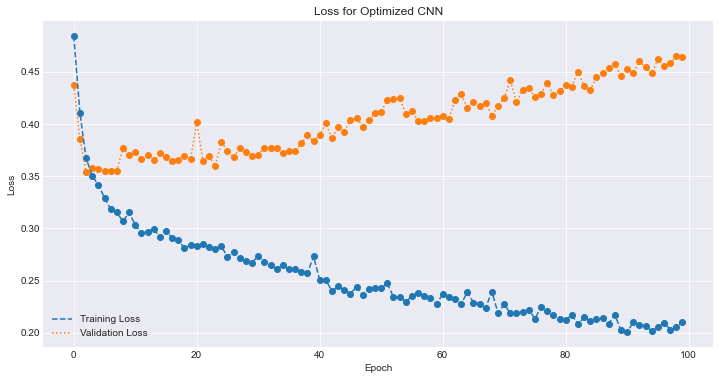

In [72]:
x_vals2 = [*range(len(history_opt1.history['loss']))]

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(x_vals2, history_opt1.history['loss'], '--', label='Training Loss')
ax.scatter(x_vals2, history_opt1.history['loss'])
ax.plot(x_vals2, history_opt1.history['val_loss'], ':', label='Validation Loss')
ax.scatter(x_vals2, history_opt1.history['val_loss'])

ax.set_xlabel('Epoch')
ax.set_ylabel('Loss')
ax.legend()

plt.title('Loss for Optimized CNN')
plt.show()

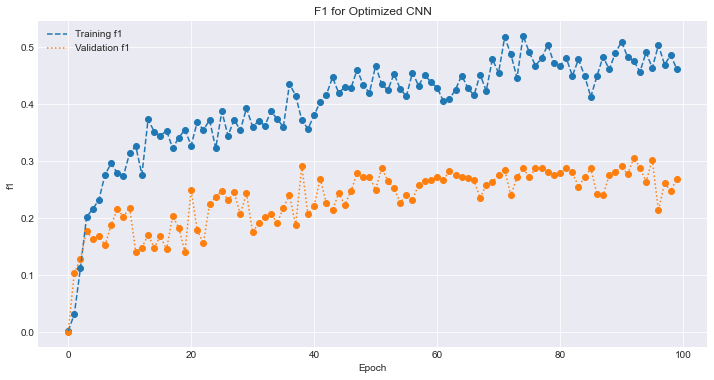

In [73]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(x_vals2, history_opt1.history['get_f1'], '--', label='Training f1')
ax.scatter(x_vals2, history_opt1.history['get_f1'])
ax.plot(x_vals2, history_opt1.history['val_get_f1'], ':', label='Validation f1')
ax.scatter(x_vals2, history_opt1.history['val_get_f1'])

ax.set_xlabel('Epoch')
ax.set_ylabel('f1')
ax.legend()

plt.title('F1 for Optimized CNN')
plt.show()

In [74]:
print(f'mean f1 on training set: {np.mean(history_opt1.history["get_f1"])}')

mean f1 on training set: 0.39928630243055524


In [75]:
print(f'mean f1 on validation set: {np.mean(history_opt1.history["val_get_f1"])}')

mean f1 on validation set: 0.23404651068150997


*Summary of Optimized CNN Training:* Both visualizations and mean f1 scores show that the model with optimized parameters has overfit the data. Overfitting occurs quickly before the 10th epoch.

#### <center> Optimized CNN Performance on The Test Set </center>

In [76]:
# make predictions, convert to class predictions, 
pred_2 = model_conv1D_optim.predict(X_test_reshaped)
pred_2 = np.where(pred_2 > 0.5, 1, 0)
print(classification_report(y_test_cnn, pred_2))
print(f'f1-score for unoptimized model test data: {f1_score(y_test_cnn, pred_2)}')

              precision    recall  f1-score   support

           0       0.89      0.91      0.90       286
           1       0.46      0.43      0.44        54

    accuracy                           0.83       340
   macro avg       0.68      0.67      0.67       340
weighted avg       0.82      0.83      0.83       340

f1-score for unoptimized model test data: 0.4423076923076923


*Summary of Optimized CNN:* Even with overfitting on the training data, this model performed better on the test set. *Optimized CNN f1:* $0.44$ *Unoptimized CNN f1:* $0.39$.

#### <center> Future Explorations </center>

To further explore if model improvement can be attained, the configurations for the next four best performing models from randomizedsearchCV can trained to analyze if they overfit and see what f1 scores they attain on the test data. 

### <center>Sources</center>
<br>
1. Heart Attack. Johns Hopkins Medicine. Accessed October 8, 2021. https://www.hopkinsmedicine.org/health/conditions-and-diseases/heart-attack
<br>
<br>
2. Heart Disease Facts. Centers for Disease Control and Prevention. Accessed October 9, 2021. https://www.cdc.gov/heartdisease/facts.htm
<br>
<br>
3. Golovenkin, S.E.; Gorban, Alexander; Mirkes, Evgeny; Shulman, V.A.; Rossiev, D.A.; Shesternya, P.A.; et al. (2020): Myocardial infarction complications Database. University of Leicester. Dataset. https://doi.org/10.25392/leicester.data.12045261.v3 
<br>
<br>
4. U. Rajendra Acharya, Hamido Fujita, Shu Lih Oh, Yuki Hagiwara, Jen Hong Tan, Muhammad Adam,
Application of deep convolutional neural network for automated detection of myocardial infarction using ECG signals,
Information Sciences,
Volumes 415–416,
2017,
Pages 190-198,
ISSN 0020-0255,
https://doi.org/10.1016/j.ins.2017.06.027.
<br>
<br>
5. Wang HM, Zhao W, Jia DY, et al. Myocardial Infarction Detection Based on Multi-lead Ensemble Neural Network. Annu Int Conf IEEE Eng Med Biol Soc. 2019;2019:2614-2617. doi:10.1109/EMBC.2019.8856392
<br>
<br>
6. Xiong P, Xue Y, Liu M, Du H, Wang H, Liu X. Sheng Wu Yi Xue Gong Cheng Xue Za Zhi. 2020;37(1):142-149. doi:10.7507/1001-5515.201904028